# Introduction

In this project, you'll work as a data scientist for an investment firm that is interested in investing in the **Initial Public Offerings (IPO) in the Indian market**. Your task is to build a deep learning classification model to determine if there will be **listing gains for the IPO.** Listing gains are the percentage increase in the share price of a company from its IPO issue price on the day of listing.

The dataset we'll be using for this project contains information on past IPOs in the Indian market and comes from [moneycontrol](https://www.moneycontrol.com/ipo/listed-ipos/?classic=true#google_vignette).

#Data Dictionary

The data consists of following columns:

`Date`: date when the IPO was listed

`IPOName`: name of the IPO

`Issue_Size`: size of the IPO issue, in INR Crores

`Subscription_QIB`: number of times the IPO was subscribed by the QIB (Qualified Institutional Buyer) investor category

`Subscription_HNI`: number of times the IPO was subscribed by the HNI (High Networth Individual) investor category

`Subscription_RII`: number of times the IPO was subscribed by the RII (Retail Individual Investors) investor category

`Subscription_Total`: total number of times the IPO was subscribed overall

`Issue_Price`: the price in INR at which the IPO was issued

`Listing_Gains_Percent`: is the percentage gain in the listing price over the issue price

#Import libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

#Read data set

In [3]:
ipo = pd.read_csv("Indian_IPO_Market_Data.csv")

print(ipo.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'Indian_IPO_Market_Data.csv'

In [ ]:
#Analyzing shape and statistics
print("Shape: ",ipo.shape)
print("Columns info: \n",ipo.info)
print("Statistics: ",ipo.describe(include='all'))

Shape:  (319, 9)
Columns info: 
 <bound method DataFrame.info of         Date           IPOName  Issue_Size  Subscription_QIB  \
0    03/02/10    Infinite Comp      189.80             48.44   
1    08/02/10    Jubilant Food      328.70             59.39   
2    15/02/10    Syncom Health       56.25              0.99   
3    15/02/10  Vascon Engineer      199.80              1.12   
4    19/02/10      Thangamayil        0.00              0.52   
..        ...              ...         ...               ...   
314  26/08/22        Syrma SGS      840.13             42.42   
315  06/09/22  Dreamfolks Serv      562.10             27.48   
316  15/09/22              TMB      792.00              0.51   
317  26/09/22  Harsha Engineer      755.00            113.82   
318  17/10/22  Electronics Mar      500.00             58.81   

     Subscription_HNI  Subscription_RII  Subscription_Total  Issue_Price  \
0              106.02             11.08               43.22          165   
1             

#First insights

There is a column data that is expressed in full date format - DD/MM/YY. It should be transformed into 3 separated columns [DD , MM , YY]

It is possible to see that the target columns (Listing_gains_percent) is listed in continuous values. It should be transformed into to categorical variable (1 or 0) in order to make some classifications

In [ ]:
#Crate categorical target variable
ipo_mod = ipo.copy()
ipo_mod['Listing_Gains_Profit'] = (ipo_mod['Listing_Gains_Percent'] > 0).astype(int)
ipo_mod = ipo_mod.drop('Listing_Gains_Percent',axis=1)

#Convert Date in three columns
ipo_mod['Date '] = pd.to_datetime(ipo_mod['Date '], format='%d/%m/%y') # Convert to datetime
ipo_mod['Day'] = ipo_mod['Date '].dt.day
ipo_mod['Month'] = ipo_mod['Date '].dt.month
ipo_mod['Year'] = ipo_mod['Date '].dt.year
ipo_mod = ipo_mod.drop('Date ', axis=1) # Remove original 'Date' column


In [ ]:
ipo_mod.head()

,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Profit,Day,Month,Year
0,Infinite Comp,189.80,48.44,106.02,11.08,43.22,165,1,3,2,2010
1,Jubilant Food,328.70,59.39,51.95,3.79,31.11,145,0,8,2,2010
2,Syncom Health,56.25,0.99,16.60,6.25,5.17,75,1,15,2,2010
3,Vascon Engineer,199.80,1.12,3.65,0.62,1.22,165,0,15,2,2010
4,Thangamayil,0.00,0.52,1.52,2.26,1.12,75,0,19,2,2010


In [ ]:
# prompt: count missing values in df

print(ipo_mod.isnull().sum())


IPOName                 0
Issue_Size              0
Subscription_QIB        0
Subscription_HNI        0
Subscription_RII        0
Subscription_Total      0
Issue_Price             0
Listing_Gains_Profit    0
Day                     0
Month                   0
Year                    0
dtype: int64


#Target distribution

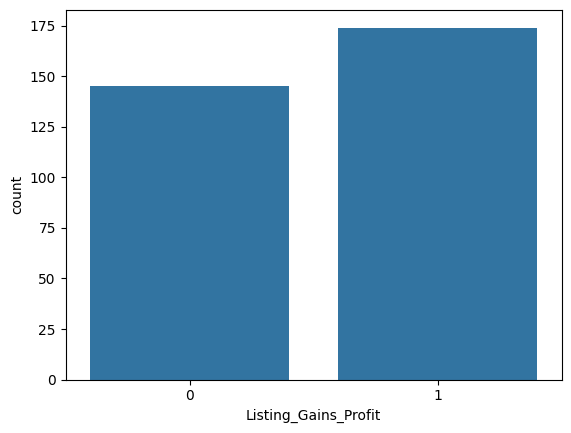

,proportion
Listing_Gains_Profit,
1,54.545455
0,45.454545


In [ ]:
#generate target distribution
sns.countplot(x='Listing_Gains_Profit', data=ipo_mod)
plt.show()

# Calculate the percentage of IPOs with listing gains and losses
listing_gains_counts = ipo_mod['Listing_Gains_Profit'].value_counts(normalize=True) * 100

# Print the target distribution in percentages
listing_gains_counts



We can see from table above that is target distribution is well balanced between 1 or 0.

1 Labels (Had profit) - 55%

0 label (don't had profit) - 45%

#Variable Selection

We are going to select the main variable according to correlation between the features and target variable (List_Gain_Profit)

Issue_Size                 NaN
Subscription_QIB      0.323499
Subscription_HNI      0.271879
Subscription_RII      0.240842
Subscription_Total    0.283340
Issue_Price                NaN
Day                        NaN
Month                      NaN
Year                  0.242480
Name: Listing_Gains_Profit, dtype: float64


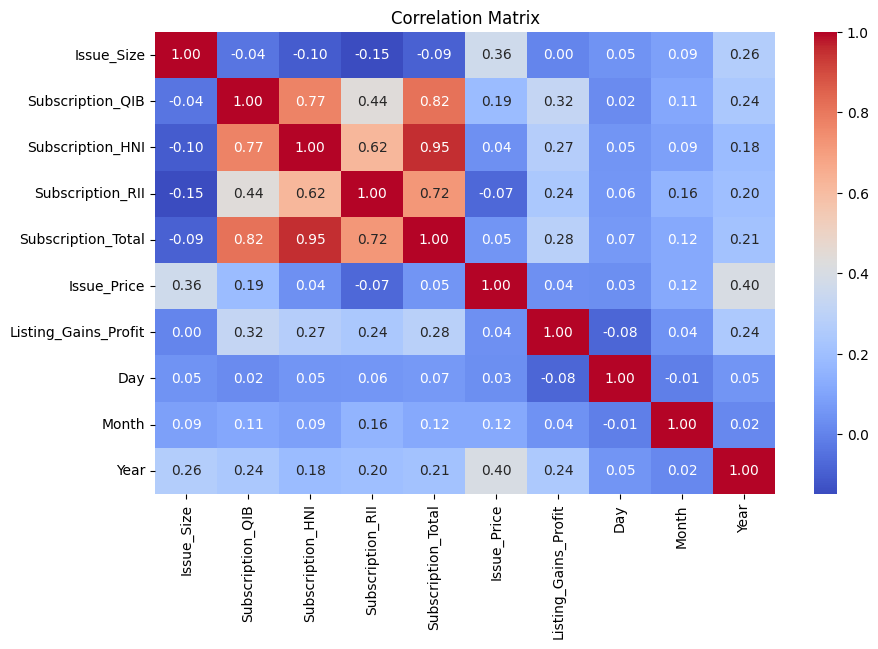

In [ ]:
# prompt: generate correlation matrix according to target variable

# Calculate the correlation matrix
correlation_matrix = ipo_mod.select_dtypes(include=np.number).corr()

# Get the correlation with 'Listing_Gains_Profit'
correlation_with_target = correlation_matrix[correlation_matrix>0.2]['Listing_Gains_Profit'].drop('Listing_Gains_Profit')

# Print the correlations
print(correlation_with_target)

# Plot the correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


From the correlation matrix above, we have selected feature with correlation greater than 0.20, regarding list_grain_profit.

these are:

* Subscription_QIB         0.323499
* Subscription_HNI         0.271879
* Subscription_RII         0.240842
* Subscription_Total       0.283340
* Year                     0.242480

In [ ]:
features = correlation_with_target.dropna()
features = features.index.to_list()
features

['Subscription_QIB',
 'Subscription_HNI',
 'Subscription_RII',
 'Subscription_Total',
 'Year']

Plot features distribution

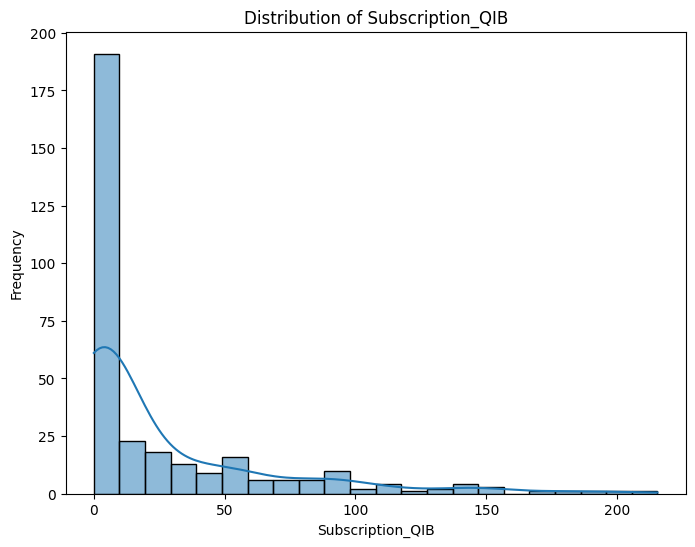

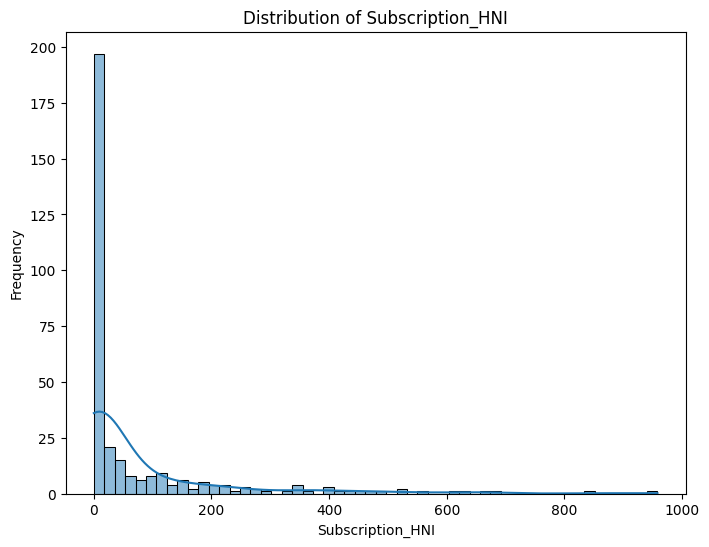

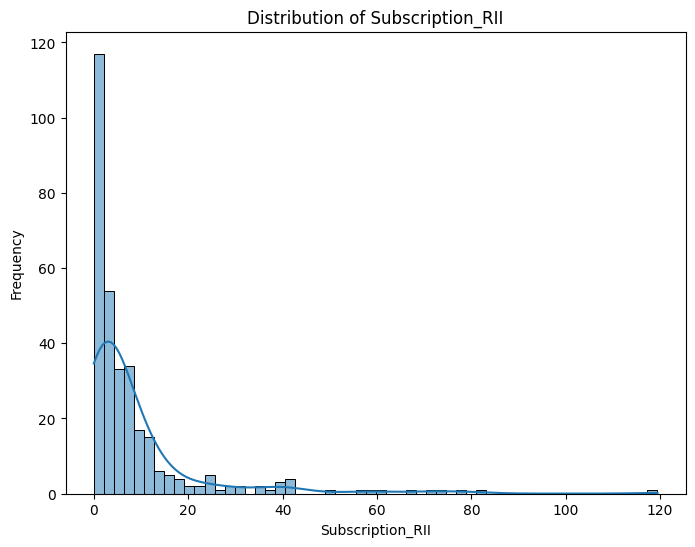

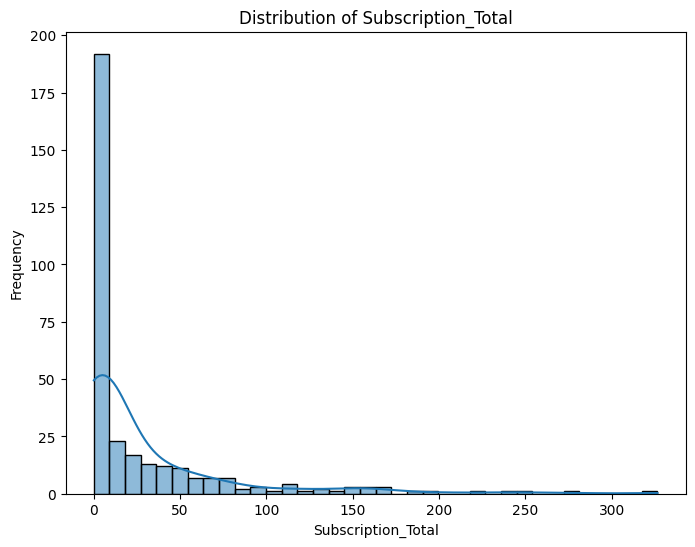

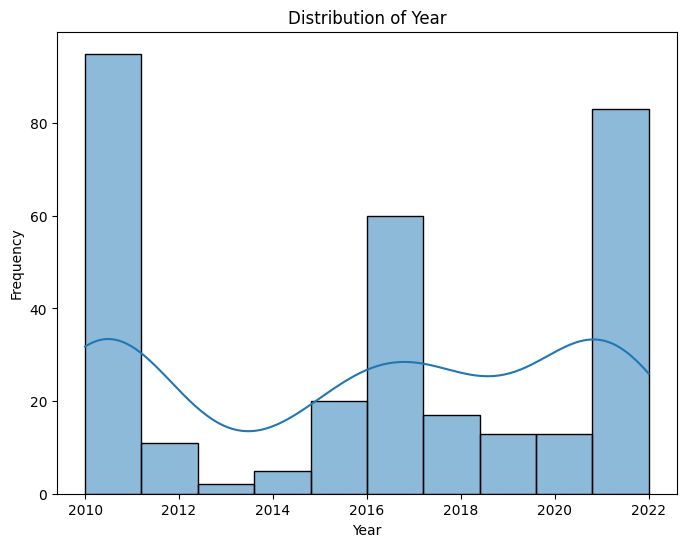

In [ ]:
# prompt: plot features distribution

# Plot features distribution
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.histplot(ipo_mod[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


We can see from distributions above that most of them are highly right skewed. Meaning that most of its values are concentrated near 0 value.

We can see as well the presence of outliers in each feature using the standard deviation formula. Let's remove them

In [ ]:
# prompt: remove outliers using std formula. print the number of outliers per feature. create new df

# Create a copy of the DataFrame to avoid modifying the original
ipo_mod_no_outliers = ipo_mod.copy()

# Define a function to remove outliers based on standard deviation
def remove_outliers_std(df, column, threshold=3):
    mean = df[column].mean()
    std = df[column].std()
    lower_bound = mean - threshold * std
    upper_bound = mean + threshold * std
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    num_outliers = len(df) - len(df_filtered)
    return df_filtered, num_outliers


# Iterate through selected features and remove outliers
num_outliers_per_feature = {}
for feature in features:
    ipo_mod_no_outliers, num_outliers = remove_outliers_std(ipo_mod_no_outliers, feature)
    num_outliers_per_feature[feature] = num_outliers

# Print the number of outliers removed for each feature
for feature, num_outliers in num_outliers_per_feature.items():
    print(f"Number of outliers removed for {feature}: {num_outliers}")

# Now 'ipo_mod_no_outliers' contains the data with outliers removed
# You can proceed with further analysis or modeling using this DataFrame


Number of outliers removed for Subscription_QIB: 8
Number of outliers removed for Subscription_HNI: 8
Number of outliers removed for Subscription_RII: 7
Number of outliers removed for Subscription_Total: 7
Number of outliers removed for Year: 0


In [ ]:
# prompt: transforme features using z_score scaler . create new df. do not use columns other than feaures in the mod df. exclude year pro transformation

from sklearn.preprocessing import MinMaxScaler

# Create a copy of the DataFrame to avoid modifying the original
mod_df = ipo_mod_no_outliers.copy()

#Exclude Year from the transformation
features_to_scale = [col for col in features if col != 'Year']

# Initialize the StandardScaler
scaler = MinMaxScaler()

# Fit and transform the selected features
scaled_features = scaler.fit_transform(mod_df[features_to_scale])

# Create a new DataFrame with the scaled features
scaled_df = pd.DataFrame(scaled_features, columns=features_to_scale, index=mod_df.index)

# Concatenate the scaled features with the original DataFrame (excluding the scaled columns and 'Year')
ipo_scaled = pd.concat([scaled_df, mod_df[['Year','Listing_Gains_Profit']]], axis=1)

print(ipo_scaled.describe())


       Subscription_QIB  Subscription_HNI  Subscription_RII  \
count        289.000000        289.000000        289.000000   
mean           0.116584          0.102014          0.129947   
std            0.178796          0.183606          0.170401   
min            0.000000          0.000000          0.000000   
25%            0.007755          0.003239          0.026879   
50%            0.028387          0.010806          0.070885   
75%            0.152531          0.108609          0.171741   
max            1.000000          1.000000          1.000000   

       Subscription_Total         Year  Listing_Gains_Profit  
count          289.000000   289.000000            289.000000  
mean             0.156990  2015.595156              0.512111  
std              0.224190     4.382586              0.500720  
min              0.000000  2010.000000              0.000000  
25%              0.016560  2011.000000              0.000000  
50%              0.041132  2016.000000              1.

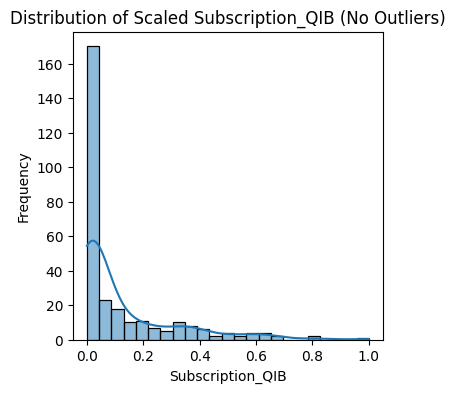

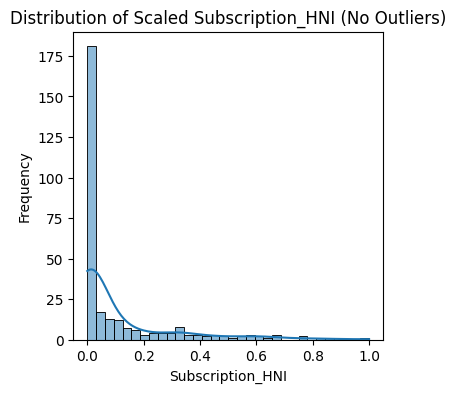

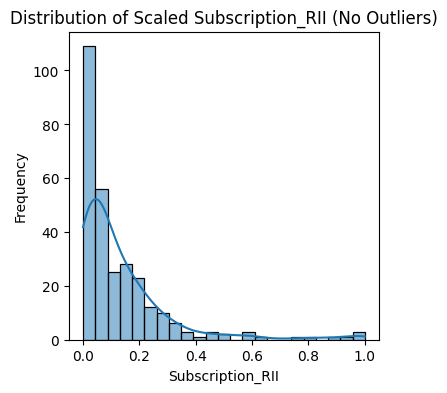

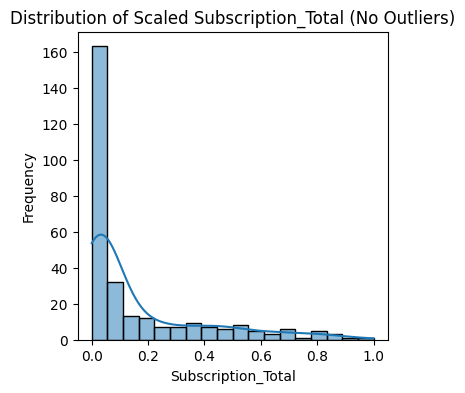

In [ ]:
# prompt: print the distribution without outliers and scaled

# Plot the distribution of scaled features without outliers


for feature in features_to_scale:
    plt.figure(figsize=(4, 4))
    sns.histplot(ipo_scaled[feature], kde=True)
    plt.title(f'Distribution of Scaled {feature} (No Outliers)')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


So far, we have scaled the dataframe using `MinMax` Scaler that let the data with their values between 0 and 1


Now we need to select **X predictors** variables and **Y target** variable

In [ ]:
X = ipo_scaled.drop(['Listing_Gains_Profit'],axis=1)
y = ipo_scaled['Listing_Gains_Profit']

# Creating the Holdout Validation Approach

During the lessons, you learned about the holdout validation approach, which works by splitting the dataset into two parts: a **training** set and a **test** set.

Let's divide train/test set in ration of 0.7/0.3

In [ ]:
# prompt: split test set with 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(173, 5) (116, 5)
(173,) (116,)


#Define the Deep Learning Classification Model

You'll need to consider the following steps while defining and building the dense deep learning model.

1. Instantiating the model

1. Adding the hidden layers

1. Selecting the activation functions -

In [ ]:
#Instantiate a model with the Keras Sequential API in TensorFlow.
model = tf.keras.Sequential()

#Let's try using two hidden layers with ReLu activation function
model.add(tf.keras.layers.Dense(32, input_shape=(X_train.shape[1],), activation='relu'))
model.add(tf.keras.layers.Dense(16, activation= 'relu'))
model.add(tf.keras.layers.Dense(8, activation= 'relu'))
model.add(tf.keras.layers.Dense(4, activation= 'relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

#Add an output layer with an appropriate number of nodes and an activation function suited to this classification task.
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In this step, we have defined the model by instantiating the sequential model class in TensorFlow's Keras. The model architecture is comprised of four hidden layers with relu as the activation function. The output layer uses a `sigmoid` activation function, which is a good choice for a binary classification model.

#Compile and Train the model

Recall that compiling a model requires us to specify the following:

1. An optimizer
1. A loss function
1. An evaluation metric

After compiling the model, you'll fit the model on training dataset.

In [ ]:
#Using Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

#compile the model - Loss - mean error. Metrics - Mean erro
model.compile(loss = 'mae', metrics=['mae'], optimizer=optimizer)

model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                     │ (None, 32)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │               5 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 899 (3.51 KB)

 Trainable params: 899 (3.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=250, verbose=0)

#Model Evaluation

Here are some of the guiding questions you should keep in mind:

1. What is the overall training accuracy on the train and test datasets?

1. Is the accuracy consistent across both the train and test datasets, or is there a chance your model is overfitting?

In [ ]:
# Evaluate the model
print(model.evaluate(X_train, y_train))
print(model.evaluate(X_test, y_test))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4998 - mae: 0.4998  
[0.48691579699516296, 0.48691579699516296]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4412 - mae: 0.4412 
[0.49219459295272827, 0.49219459295272827]
